# 0. Data Importing from kaggle

In [1]:
import os
from tqdm.notebook import tqdm
for dirname, _, filenames in tqdm(os.walk('/kaggle/input')):
    for filename in filenames:
        os.path.join(dirname, filename)
#         print(os.path.join(dirname, filename))

0it [00:00, ?it/s]

# Limiting GPU usage

In [2]:
# limit memory to prevent data leak
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    
    del logical_gpus,gpus
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


2 Physical GPUs, 2 Logical GPUs


# 1. Importing modules

In [3]:
import numpy as np
import pandas as pd
import json
import gc
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import os
train_files = glob("../input/quickdraw-doodle-recognition/train_simplified/*.csv")

# calculating data size per category
rows = 200000
# rows = 10000
rows = rows - (rows % 340)
cat_size = rows // 340
print(cat_size)
gc.collect()

588


56

# 2. Image Preprocessing 
1. converting data in text json to an image 
2. normalizing the image size
3. normalizing the image pixels


In [4]:
from PIL import Image, ImageDraw
from dask import bag
def drawStrokes(matrixOfStrokes):
    image = Image.new("RGB", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in json.loads(matrixOfStrokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    return np.array(image.resize((32,32)))/255.

In [5]:
from tqdm.notebook import tqdm
drawingArray = np.zeros((rows,32,32,3))
categories = pd.Series([None] * rows)
i = 0
for f in tqdm(train_files):
    for df in pd.read_csv(f, index_col="key_id", chunksize=1000, nrows=cat_size):
        df = df.drop(['countrycode','timestamp','recognized'],axis=1)
        imagebag = bag.from_sequence(df.drawing.values).map(drawStrokes)
        imagebag = np.array(imagebag.compute())
        categories[i:(i + imagebag.shape[0])] = df["word"].replace("\s+", "_", regex=True)
        drawingArray[i:(i + imagebag.shape[0])] = imagebag
        i += imagebag.shape[0]


  0%|          | 0/340 [00:00<?, ?it/s]

In [6]:
gc.collect()

39

In [7]:
categories.value_counts()

traffic_light    588
umbrella         588
house            588
trombone         588
paper_clip       588
                ... 
rain             588
rabbit           588
lantern          588
toaster          588
fish             588
Length: 340, dtype: int64

# 3. Train Test split

In [8]:

from sklearn.model_selection import train_test_split
indecator = pd.get_dummies(categories)
tr_x,tst_x,tr_indecator,tst_indecator = train_test_split(drawingArray, indecator, test_size=0.25,random_state=0,stratify=indecator)


In [9]:
itr = 0
for df in tr_indecator:
    print(f"{df} : {tr_indecator[df].value_counts()[1]}")
    if itr == 5:
        break
    else:
        itr+= 1

The_Eiffel_Tower : 441
The_Great_Wall_of_China : 441
The_Mona_Lisa : 441
airplane : 441
alarm_clock : 441
ambulance : 441


In [10]:
itr = 0
for df in tst_indecator:
    try:
        print(f"{df} : {tst_indecator[df].value_counts()[1]}")
    except:
        print(f"{df} : 0")
        
    if itr == 5:
        break
    else:
        itr+= 1

The_Eiffel_Tower : 147
The_Great_Wall_of_China : 147
The_Mona_Lisa : 147
airplane : 147
alarm_clock : 147
ambulance : 147


In [11]:
del drawingArray,categories
gc.collect()

63

# 4. Creating Deep learning model

In [12]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers.legacy import Adam

filepath = 'my_best_model.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor="val_loss", 
                             save_best_only=True,
                             mode='min')

In [13]:
from keras.callbacks import EarlyStopping
earlystop= EarlyStopping(monitor='val_acc', patience=6)

In [14]:
callbacks = [checkpoint,earlystop]

In [15]:
gc.collect()

84

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    
    model = Sequential()

    model.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same', input_shape=(32, 32, 3)))
    model.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
    model.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
    model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())

#     model.add(Conv2D(1024, (3,3), activation = 'relu', padding = 'same'))
#     model.add(Conv2D(1024, (3,3), activation = 'relu', padding = 'same'))
#     model.add(MaxPooling2D(2,2))
#     model.add(BatchNormalization())
    model.add(Flatten())


    
#     model.add(Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
#     model.add(Dropout(0.25))
#     model.add(BatchNormalization())
    
    model.add(Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.1)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())

    model.add(Dense(340, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer= "adam",
              metrics=['accuracy'])


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       1

In [18]:
gc.collect()

192

# 5. Training Deep learning model  

RUN 1

Epoch 1/100


2023-03-25 07:47:48.977818: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


750/750 [==============================] - 75s 65ms/step - loss: 10.3700 - accuracy: 0.0908 - val_loss: 6.1547 - val_accuracy: 0.1885
Epoch 2/100
750/750 [==============================] - 43s 58ms/step - loss: 5.8626 - accuracy: 0.2399 - val_loss: 5.4851 - val_accuracy: 0.3336
Epoch 3/100
750/750 [==============================] - 43s 58ms/step - loss: 5.5626 - accuracy: 0.2979 - val_loss: 5.3812 - val_accuracy: 0.3423
Epoch 4/100
750/750 [==============================] - 44s 58ms/step - loss: 5.3709 - accuracy: 0.3280 - val_loss: 5.0324 - val_accuracy: 0.4058
Epoch 5/100
750/750 [==============================] - 43s 58ms/step - loss: 5.2554 - accuracy: 0.3504 - val_loss: 5.2530 - val_accuracy: 0.3498
Epoch 6/100
750/750 [==============================] - 44s 58ms/step - loss: 5.1664 - accuracy: 0.3609 - val_loss: 4.8195 - val_accuracy: 0.4337
Epoch 7/100
750/750 [==============================] - 43s 58ms/step - loss: 5.1075 - accuracy: 0.3734 - val_loss: 4.9149 - val_accuracy: 0.4

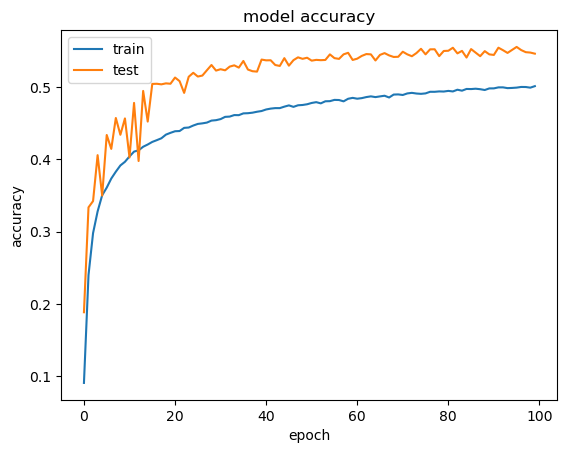

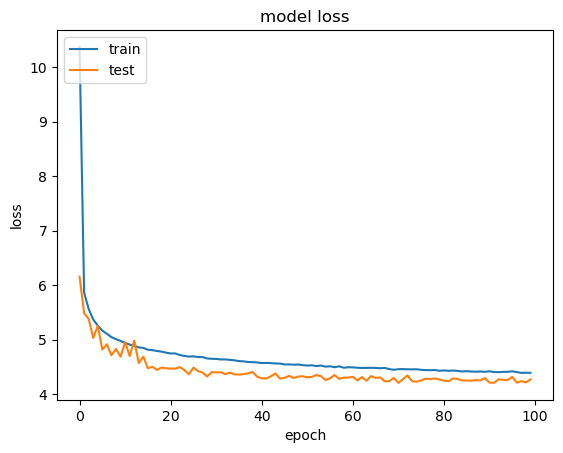

In [19]:
history = model.fit(tr_x, tr_indecator,batch_size=200,epochs=100
          ,validation_data=(tst_x,tst_indecator),callbacks=callbacks)

# history = model.fit(tr_x, tr_indecator,batch_size=128,epochs=30
#           ,validation_data=(tst_x,tst_indecator))

# history = model.fit(tr_x, tr_indecator,batch_size=128,epochs=100
#           ,validation_data=(tst_x,tst_indecator))

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [20]:
gc.collect()

13679

# 6. Saving model 

In [21]:
from tensorflow.keras.models import save_model
save_model(model,"CNN.h5")

# 7. Testing the model

In [22]:
# tr_x,tst_x,tr_indecator,tst_indecator

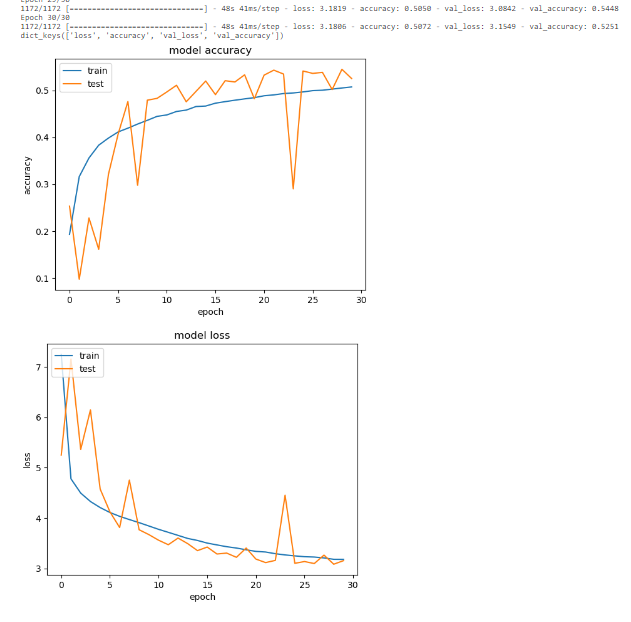

In [23]:
test = pd.read_csv('../input/quickdraw-doodle-recognition/test_simplified.csv', index_col="key_id" ,nrows=100)
ids = test.index
imagebag = bag.from_sequence(test.drawing.values).map(drawStrokes)
test_simplified = np.array(imagebag.compute())
test_simplified = test_simplified.reshape(len(test_simplified), 32, 32, 3)

In [24]:
del imagebag
gc.collect()

21

In [25]:
prediction = model.predict(test_simplified)
indexOfBigProbability = (-prediction).argsort()[:,:3]

4/4 [==============================] - 2s 47ms/step


In [26]:
gc.collect()

1967

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or var

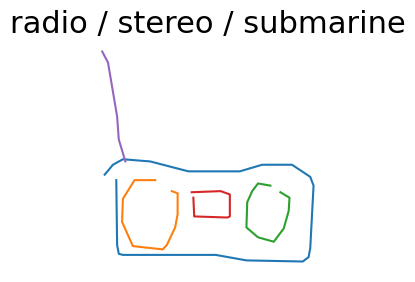

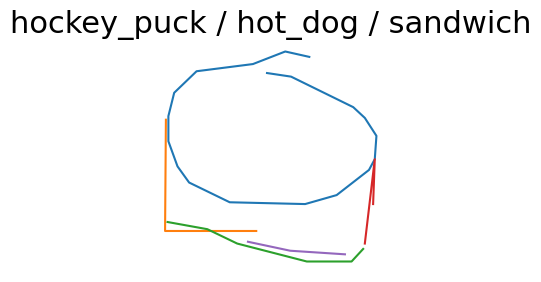

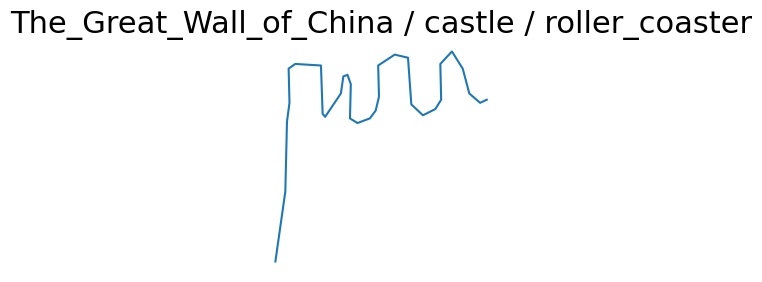

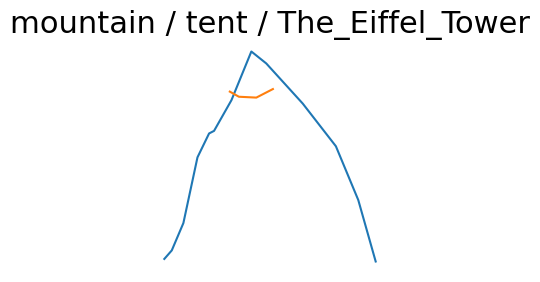

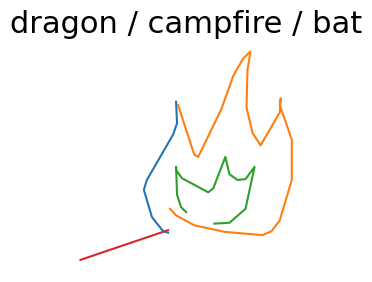

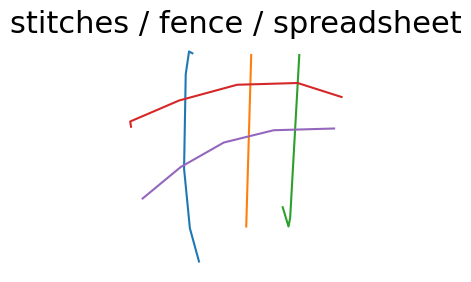

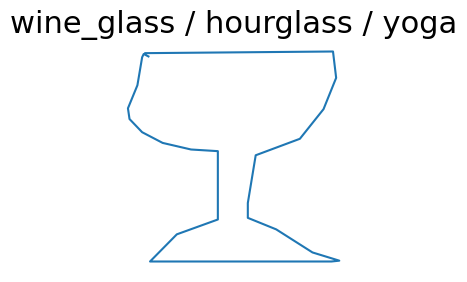

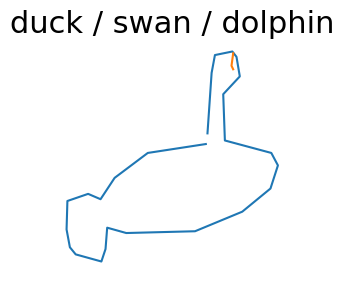

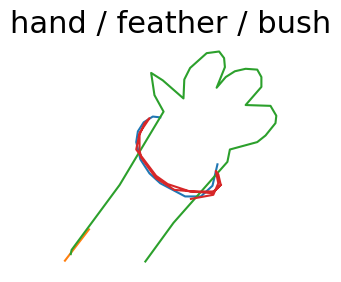

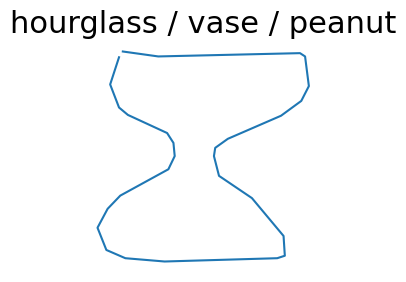

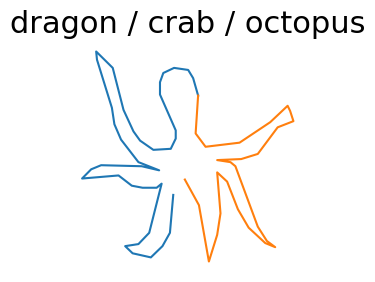

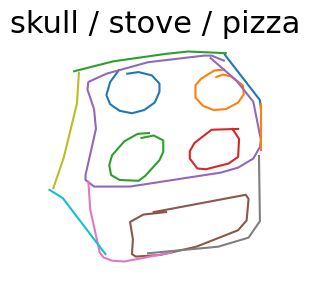

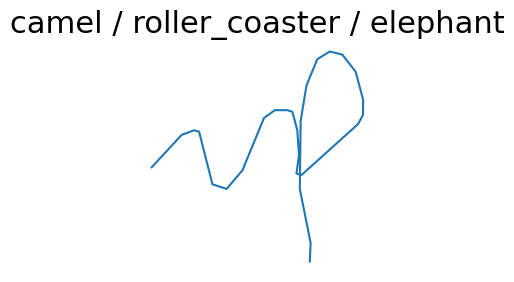

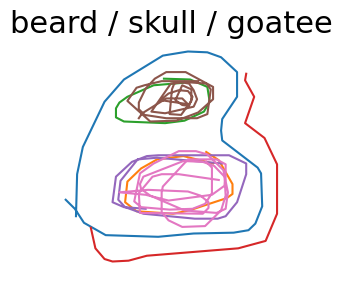

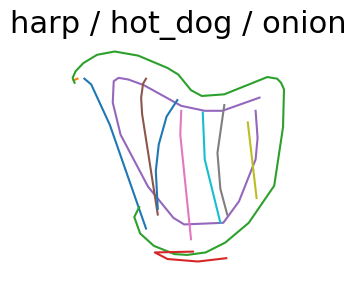

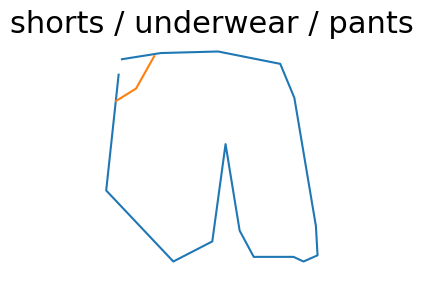

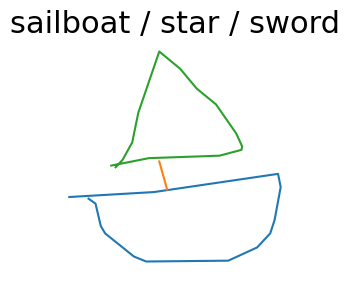

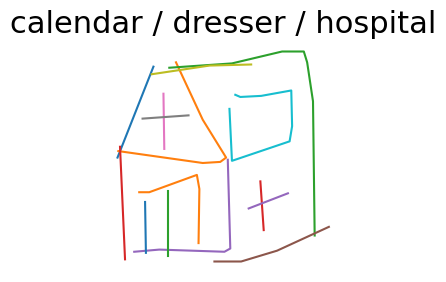

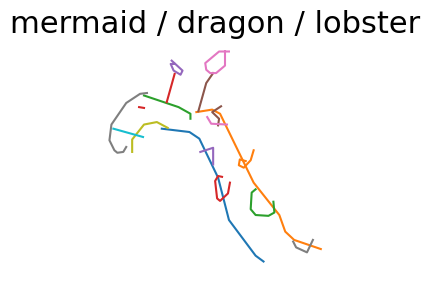

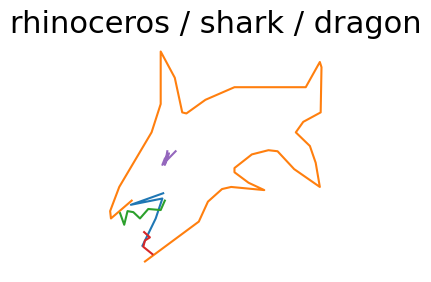

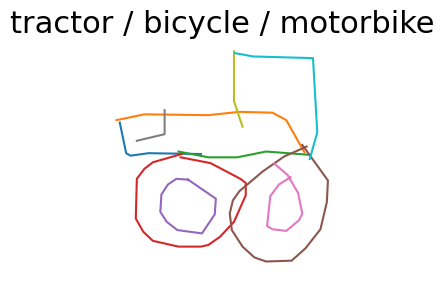

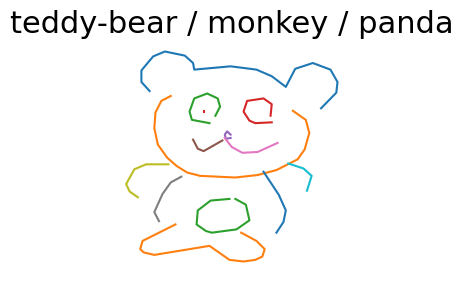

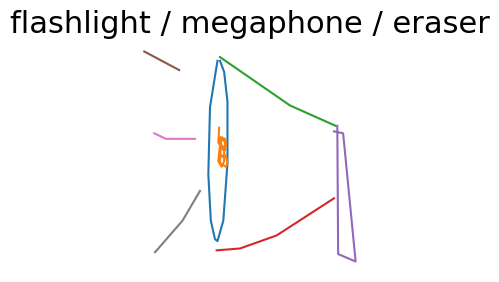

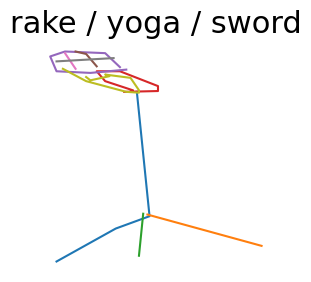

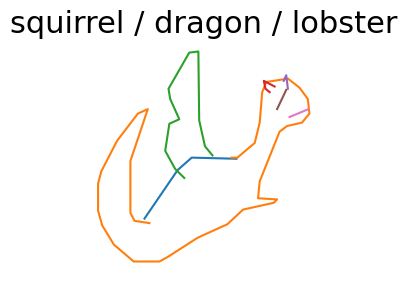

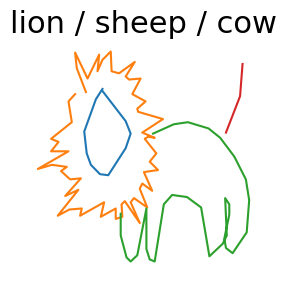

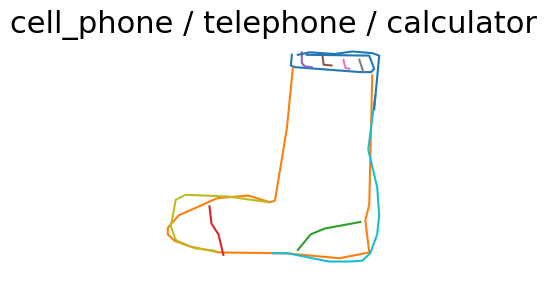

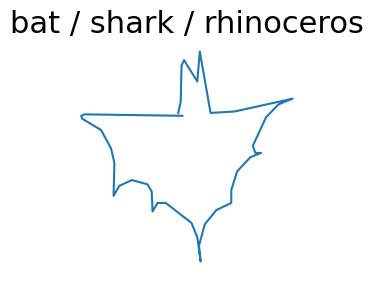

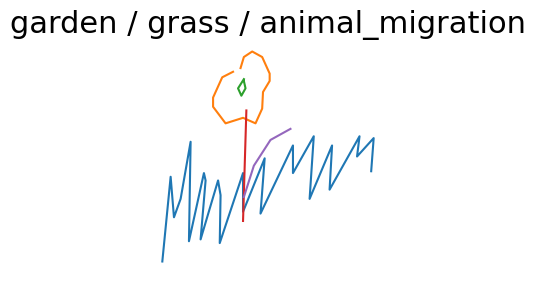

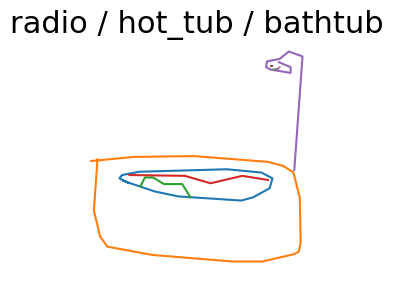

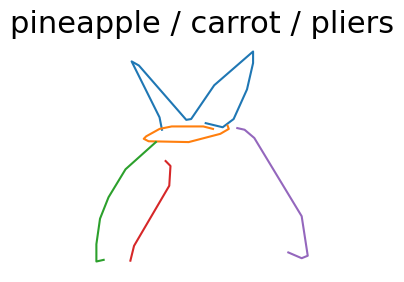

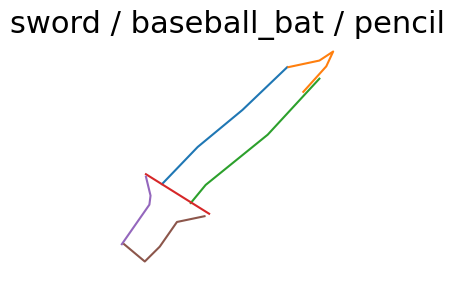

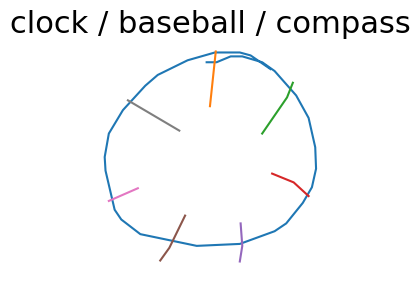

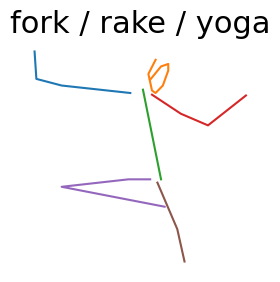

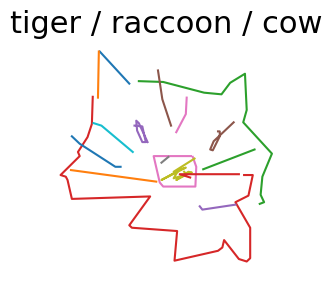

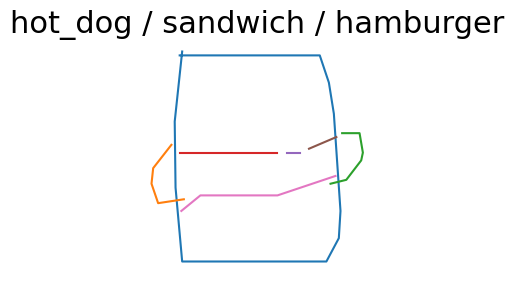

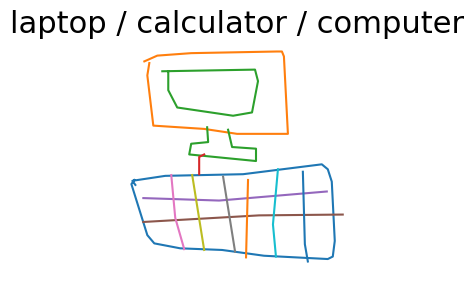

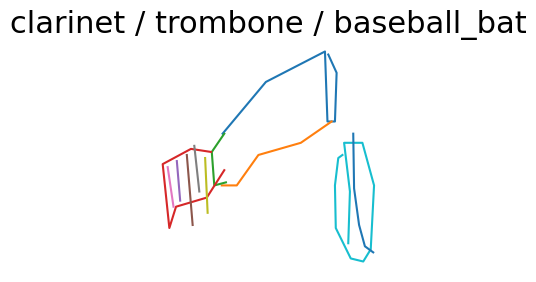

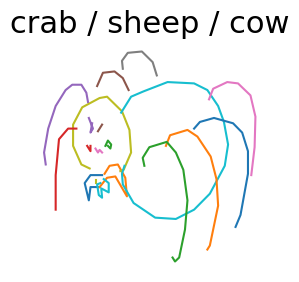

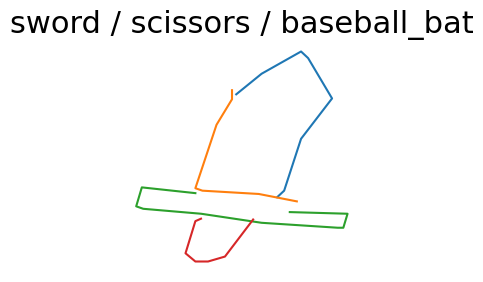

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
import ast
import warnings
warnings.filterwarnings('ignore')

raw_images = [ast.literal_eval(lst) for lst in test.loc[test.iloc[:40].index, 'drawing'].values]
j=0
for index, raw_drawing in enumerate(raw_images):
    plt.figure(figsize=(3,3))
    for x,y in raw_drawing:
        title_obj=plt.title(indecator.columns[indexOfBigProbability][j][0]
                  +" / "
                 +indecator.columns[indexOfBigProbability][j][1]
                  +" / "
                 +indecator.columns[indexOfBigProbability][j][2], fontsize=22)
        plt.setp(title_obj)
        plt.subplot(1, 1, 1)
        plt.plot(x,y)
        plt.axis('off')
    plt.gca().invert_yaxis()
    j+=1